These are the metrics output run daily: https://noaa-gestofs-pds.s3.amazonaws.com/index.html#_post_processing/_metrics/

provided for each station every day

e.g. https://noaa-gestofs-pds.s3.amazonaws.com/_post_processing/_metrics/20250319/stofs_2d_glo.1611400.cwl.csv



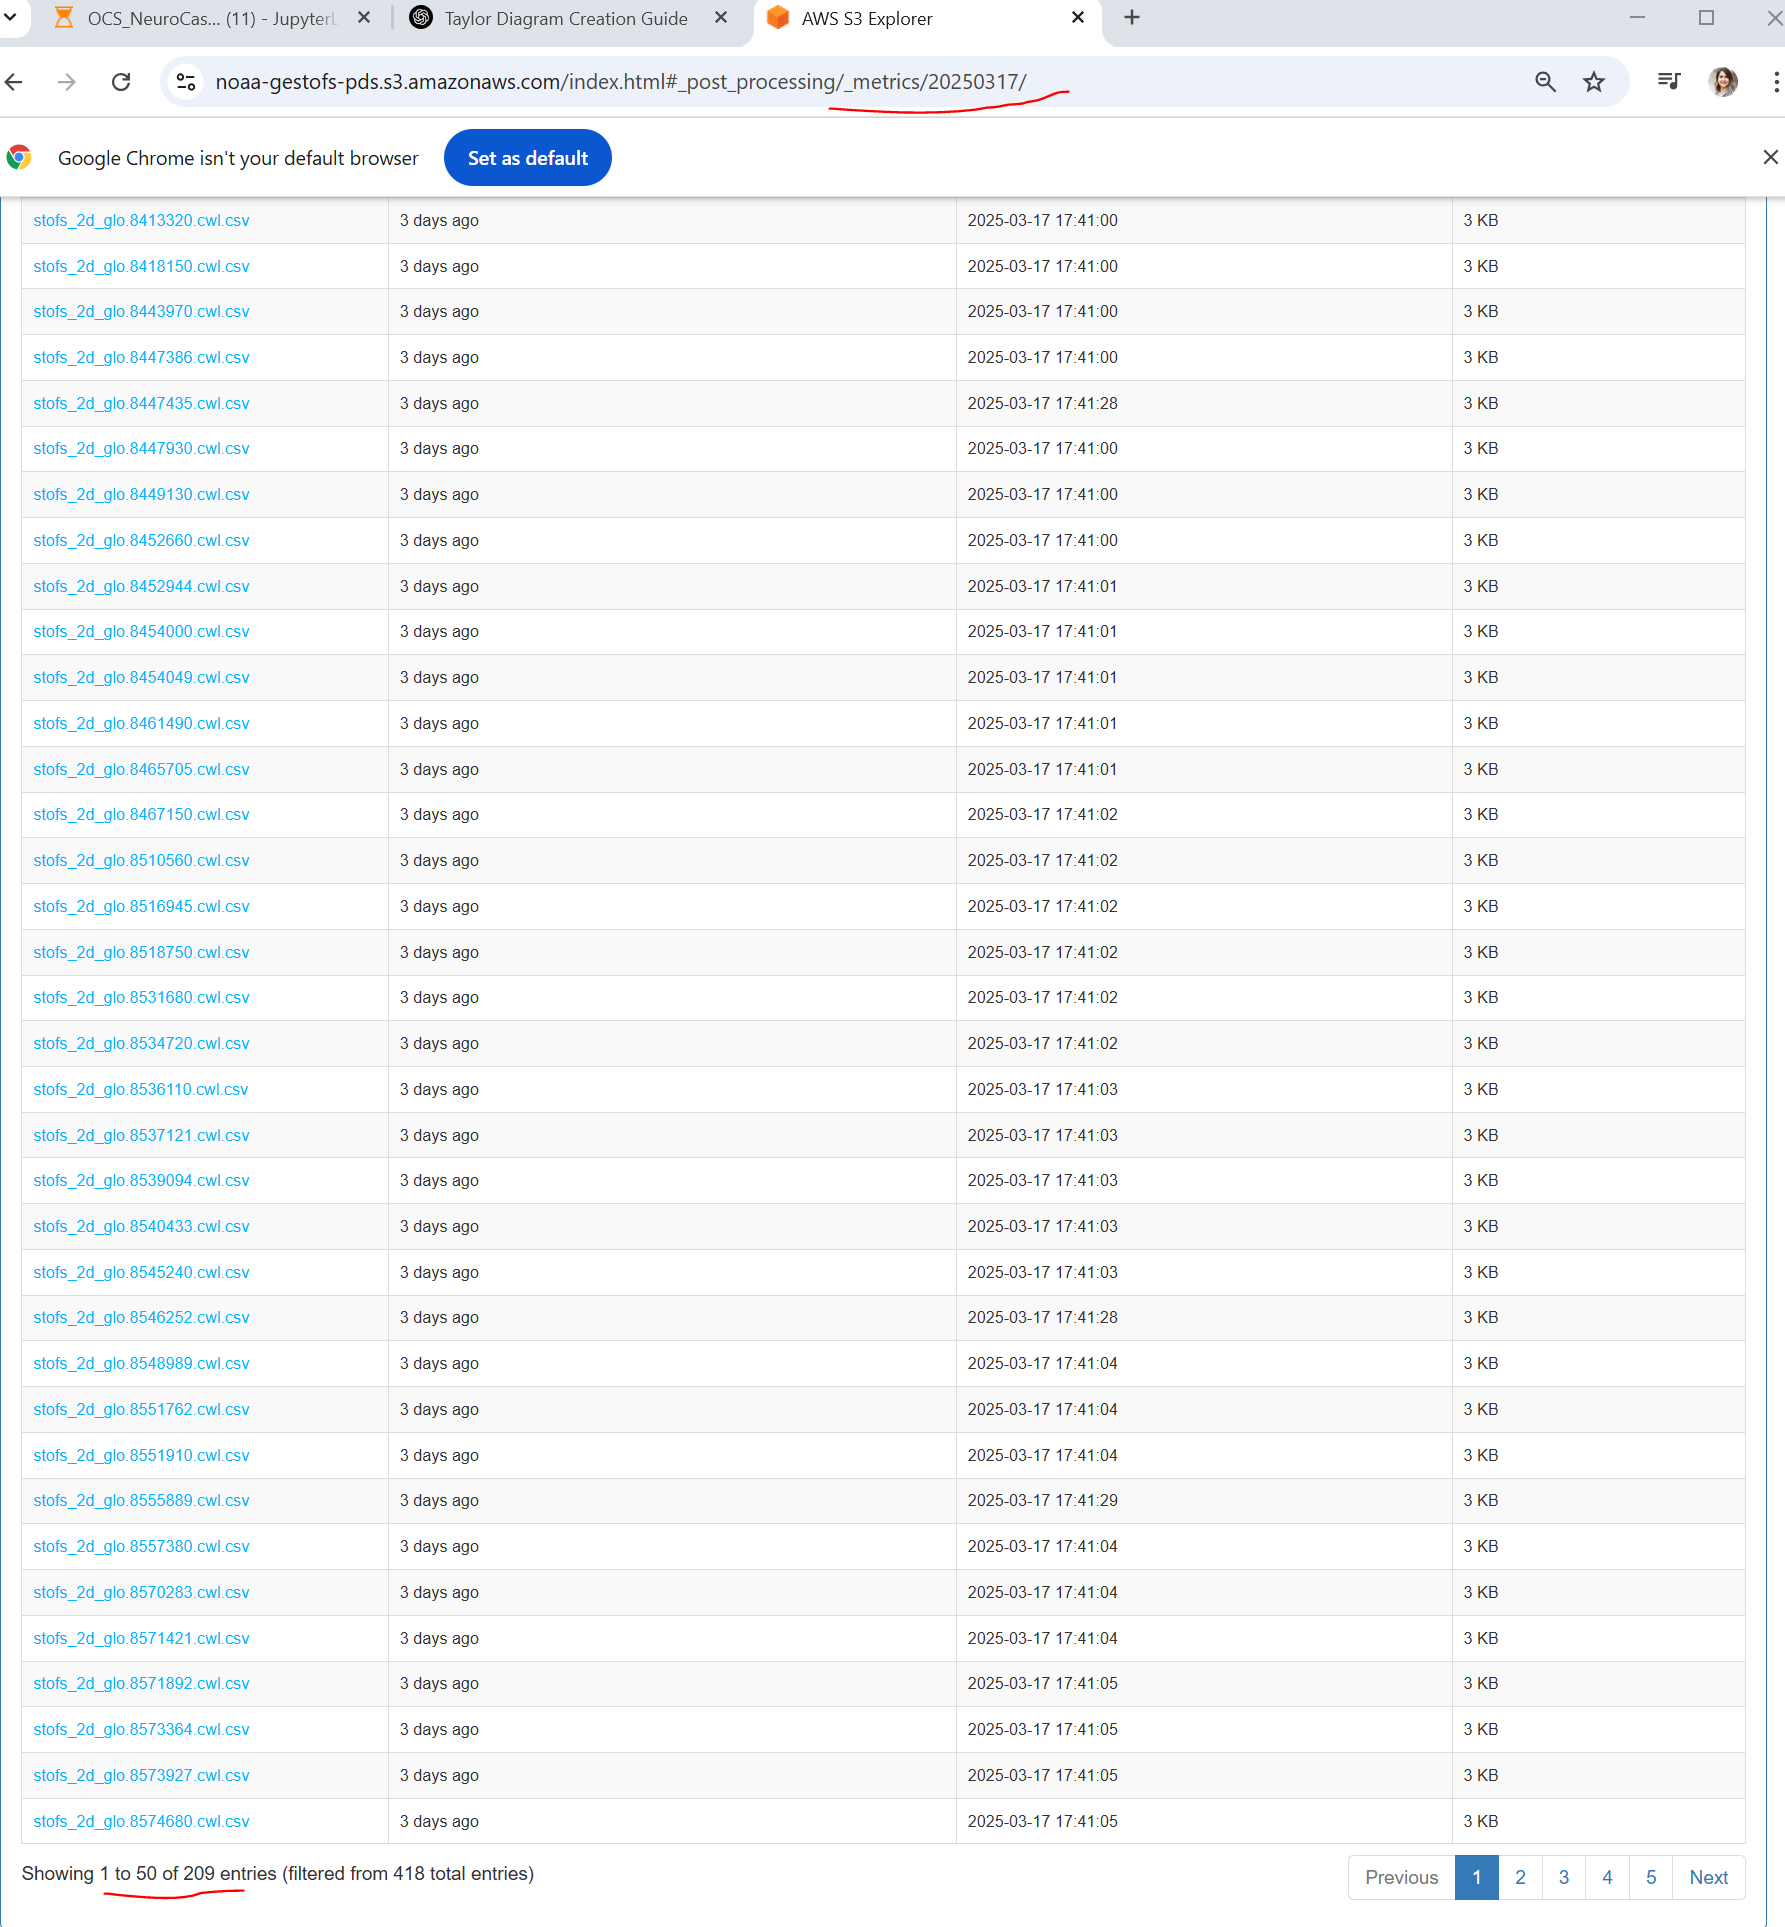



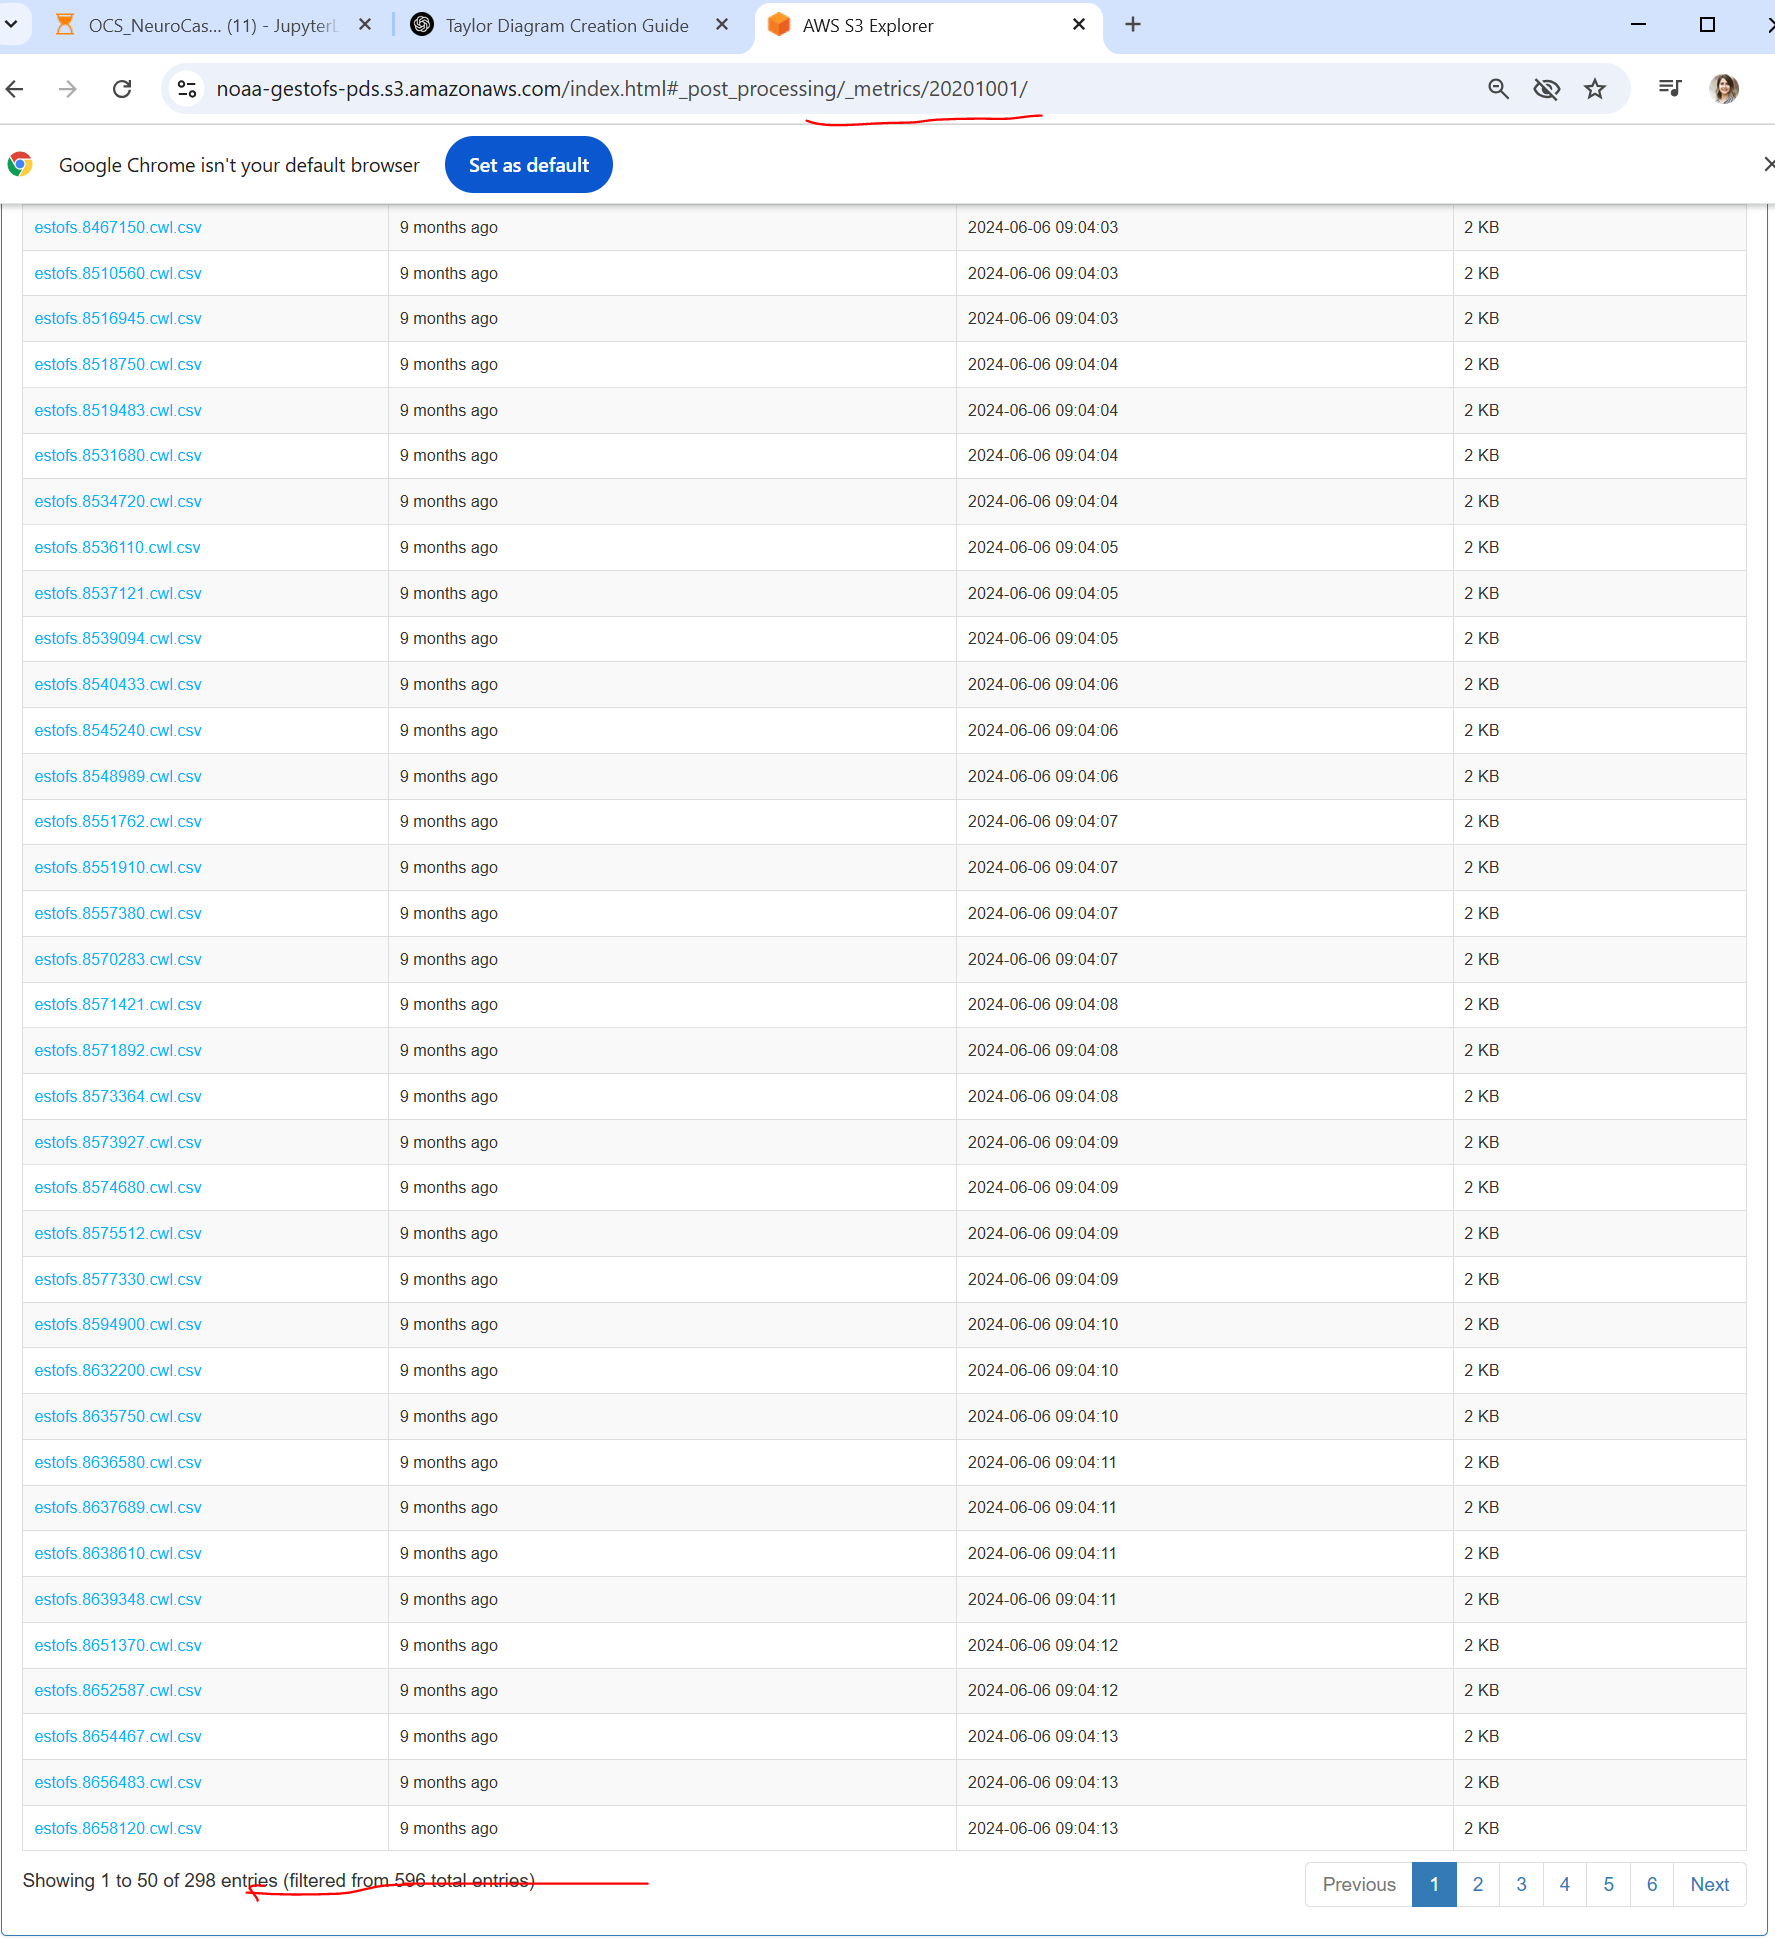



In [1]:
import pandas as pd
import s3fs
import matplotlib.pyplot as plt


missingdata for some stations

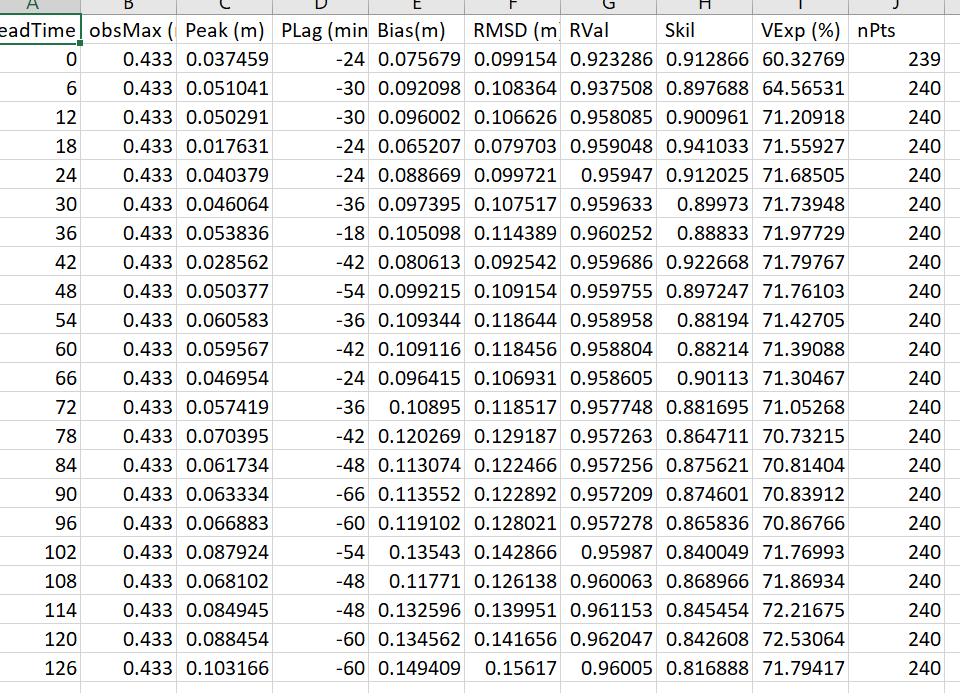


Some iles are empty:

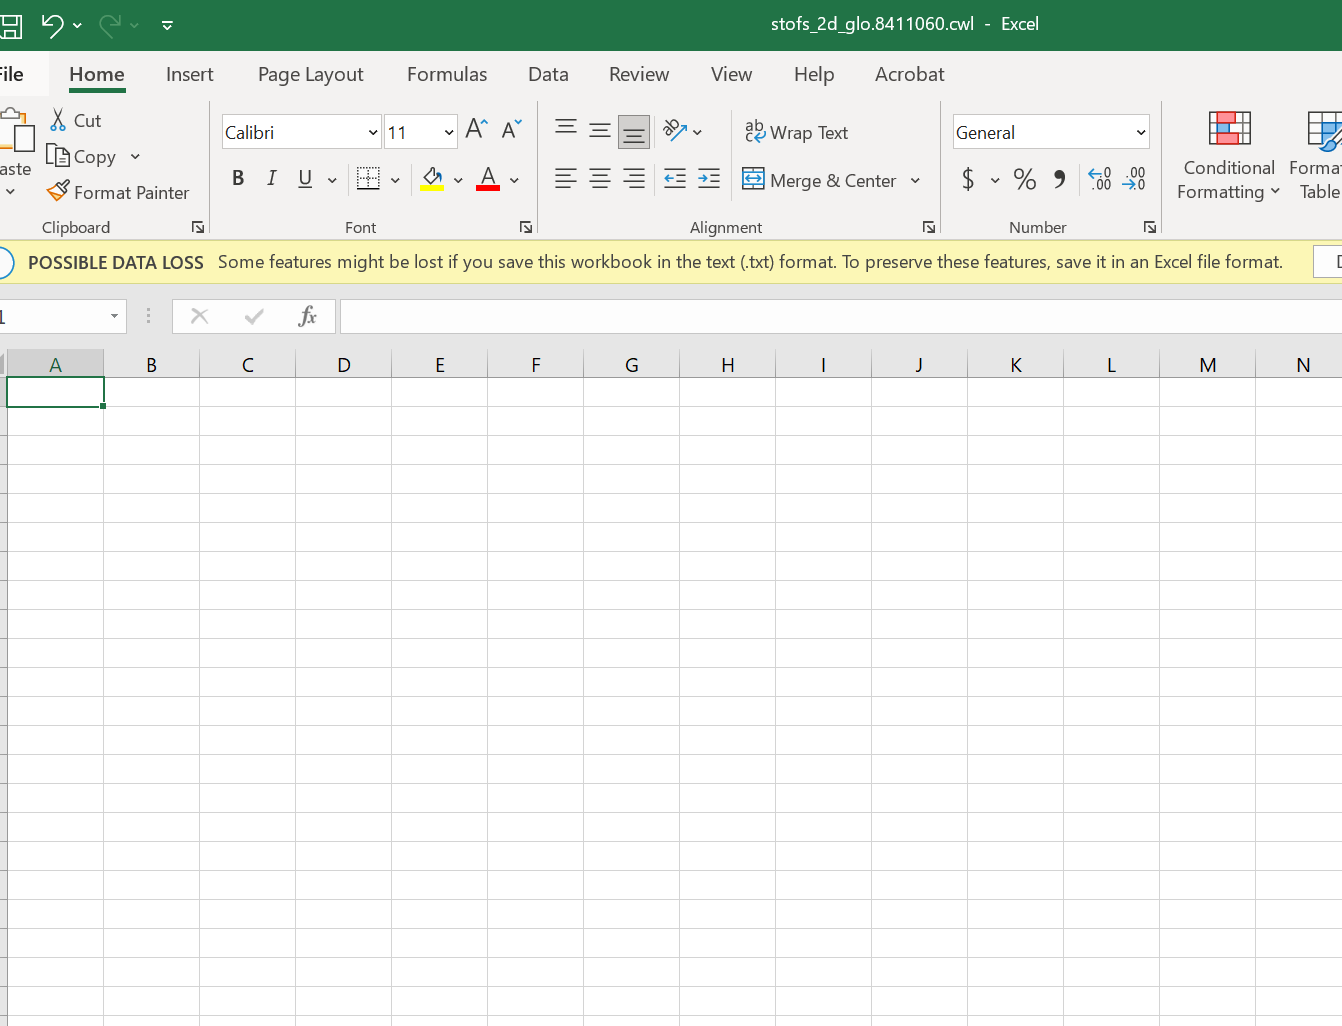

In [1]:
import pandas as pd
import s3fs
import matplotlib.pyplot as plt


In [6]:

# Define the base S3 bucket path
bucket_path = "s3://noaa-gestofs-pds/_post_processing/_metrics/"

# Initialize S3 filesystem (anonymous access for public buckets)
fs = s3fs.S3FileSystem(anon=True)

# List all directories (date-named folders like "20201015/")
date_dirs = fs.ls(bucket_path)

rmsd_data = {}
skil_data = {}
bias_data = {}


for date_dir in date_dirs:
    
    folder_name = date_dir.strip("/").split("/")[-1]
    if not folder_name.isdigit() or len(folder_name) < 8:
        continue  # Skip if it's not a valid date folder

    date = f"{folder_name[:4]}-{folder_name[4:6]}-{folder_name[6:8]}"  # Format as YYYY-MM-DD

    print(f"Processing: {date_dir} (Date: {date})")

    csv_files = fs.glob(f"{date_dir}/*.csv")

    # Filter files to include only those with "estofs." but exclude "estofs_atl."
    csv_files = [file for file in csv_files if "estofs." in file or "stofs_2d_glo." in file]

    for file in csv_files:
        try:
            # Read CSV file
            with fs.open(file, 'r') as f:
                df = pd.read_csv(f, delimiter=',')  # Adjust delimiter if needed

            # Validate required columns exist
            required_cols = ["LeadTime (HRS)", " RMSD (m)", " Skil", " Bias(m)"]
            if not all(col in df.columns for col in required_cols):
                print(f"Skipping {file} (Missing Columns)")
                continue
            
            # Initialize 
            if date not in rmsd_data:
                rmsd_data[date] = {"Date": date}
                skil_data[date] = {"Date": date}
                bias_data[date] = {"Date": date}

            # Extract RMSD and Skil by LeadTime
            for _, row in df.iterrows():
                lead_time = int(row["LeadTime (HRS)"])  # Convert to integer for consistency
                rmsd_value = row[" RMSD (m)"]
                skil_value = row[" Skil"]
                bias_value = row[" Bias(m)"]

                # Store values 
                rmsd_data[date][lead_time] = rmsd_value
                skil_data[date][lead_time] = skil_value
                bias_data[date][lead_time] = bias_value
                

        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue  

# Convert dictionaries to DataFrames
rmsd_df = pd.DataFrame.from_dict(rmsd_data, orient="index").sort_values(by="Date")
skil_df = pd.DataFrame.from_dict(skil_data, orient="index").sort_values(by="Date")
bias_df = pd.DataFrame.from_dict(bias_data, orient="index").sort_values(by="Date")

# column order (Date first, then sorted LeadTime columns)
rmsd_df = rmsd_df[["Date"] + sorted([col for col in rmsd_df.columns if col != "Date"])]
skil_df = skil_df[["Date"] + sorted([col for col in skil_df.columns if col != "Date"])]
bias_df = bias_df[["Date"] + sorted([col for col in bias_df.columns if col != "Date"])]


# Save to CSV
rmsd_df.to_csv("RMSD_data.csv", index=False)
skil_df.to_csv("Skil_data.csv", index=False)
bias_df.to_csv("bias_data.csv", index=False)

print("Saved: RMSD_data.csv, Skil_data.csv and bias_data.csv")


Processing: noaa-gestofs-pds/_post_processing/_metrics/20200826 (Date: 2020-08-26)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200827 (Date: 2020-08-27)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200828 (Date: 2020-08-28)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200829 (Date: 2020-08-29)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200830 (Date: 2020-08-30)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200831 (Date: 2020-08-31)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200901 (Date: 2020-09-01)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200902 (Date: 2020-09-02)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200914 (Date: 2020-09-14)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200915 (Date: 2020-09-15)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200916 (Date: 2020-09-16)
Processing: noaa-gestofs-pds/_post_processing/_metrics/20200917 (Date: 2020-09-17)
Proc